In [80]:
from TimeSeries_impact import utilities, ts_analysis, impact, plot_functions

import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np

from imp import reload

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Create dataset

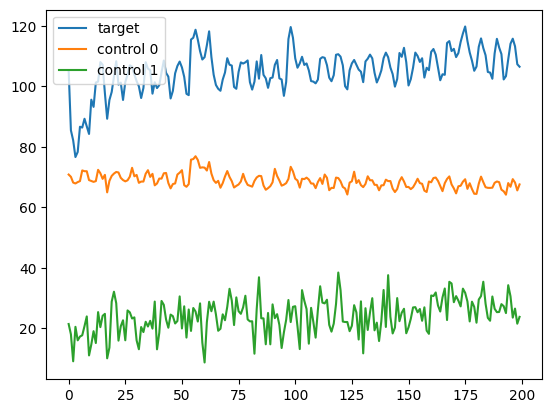

In [81]:
# create fake data where the control has the same underlying seasonal component as target
reload(utilities)
ts = utilities.make_time_serie(200, freq=[7], nbr_rand_event=5)
data = pd.DataFrame()
data["target"] = ts["obs"]
for i in range(len(ts["control"])):
    data[f"control {i}"] = ts["control"][i]

data.plot()
plt.show()


# Time series analysis

In [12]:
# create TSA object
reload(ts_analysis)
TSA = ts_analysis.TSA(data)

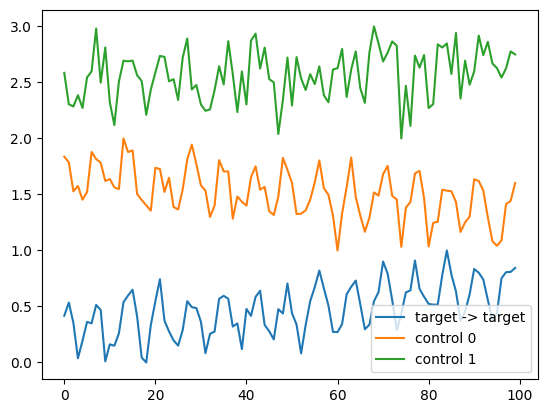

In [10]:
# check normalized and shifted ts
TSA.plot_scaled_view()

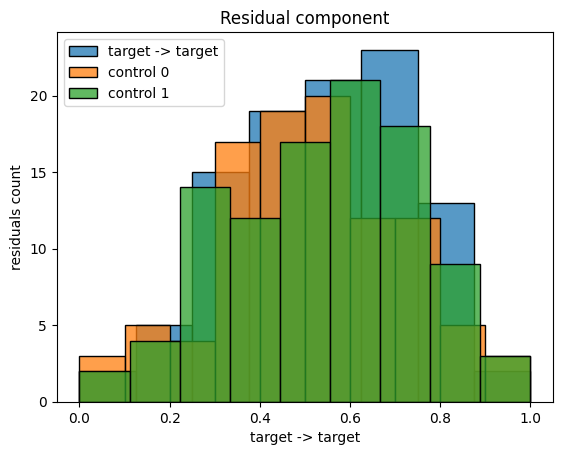

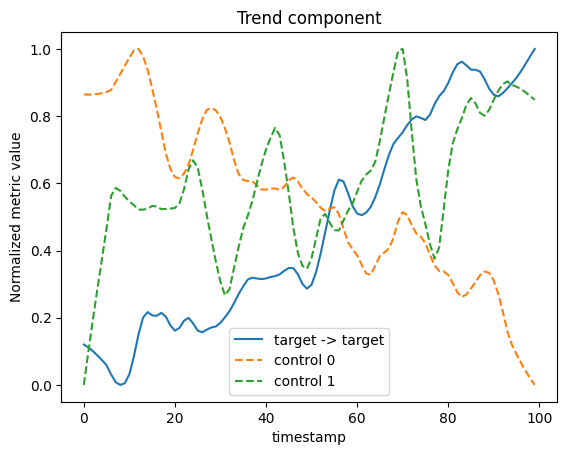

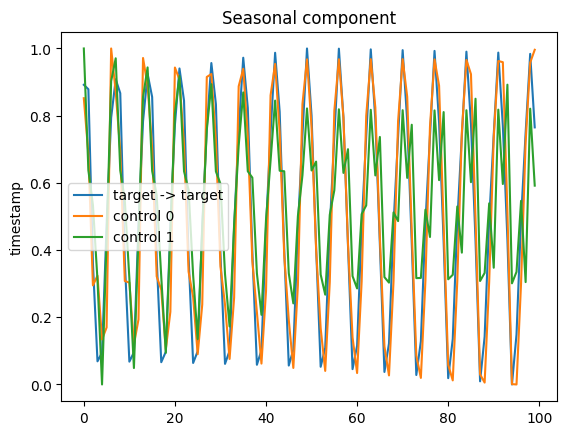


Analysis results

Similarity of residuals
                             control 0  control 1
Bhattacharyya Distance        0.002521   0.000635
Kullback-Leibler Divergence   0.009779   0.002459
Hellinger Distance            0.050176   0.025199
Wasserstein Distance          0.027531   0.010325
Kolmogorov test               0.130000   0.070000

Similarity of seasonlity
   control 0  control 1
0   0.932295   0.796501

Correlation of the time series
(                  target -> target  control 0  control 1
target -> target          1.000000   0.274911   0.378291
control 0                 0.274911   1.000000   0.227705
control 1                 0.378291   0.227705   1.000000,                   target -> target  control 0  control 1
target -> target          1.000000   0.322736   0.397696
control 0                 0.322736   1.000000   0.210573
control 1                 0.397696   0.210573   1.000000,                   target -> target  control 0  control 1
target -> target          1.000000 

In [14]:

# plot component from decomposition
TSA.plot()
TSA.plot_component()

# analyse the similarity of the components
print()
print("Analysis results")
res_res, res_seas = TSA.analyze()
corr = TSA.correlation()

print()
print("Similarity of residuals")
print(res_res)

print()
print("Similarity of seasonality")
print(res_seas)

print()
print("Correlation of the time series")
print(corr)

# Simulation and power 

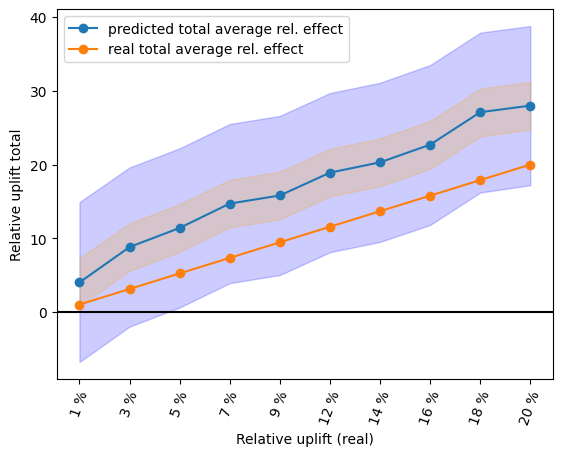

In [68]:
# perform simulation to get "power" of the model

impact_class = impact.SimImpact(data)

# single simulation
relup = np.linspace(0.01, 0.2, 10)
impact_class.make_sim(relup_list=relup, test_size=14)
fig = impact_class.plot_sim_rel()
display(fig)

# multiple simulations

Keys dict_keys(['0.0100', '0.0311', '0.0522', '0.0733', '0.0944', '0.1156', '0.1367', '0.1578', '0.1789', '0.2000'])


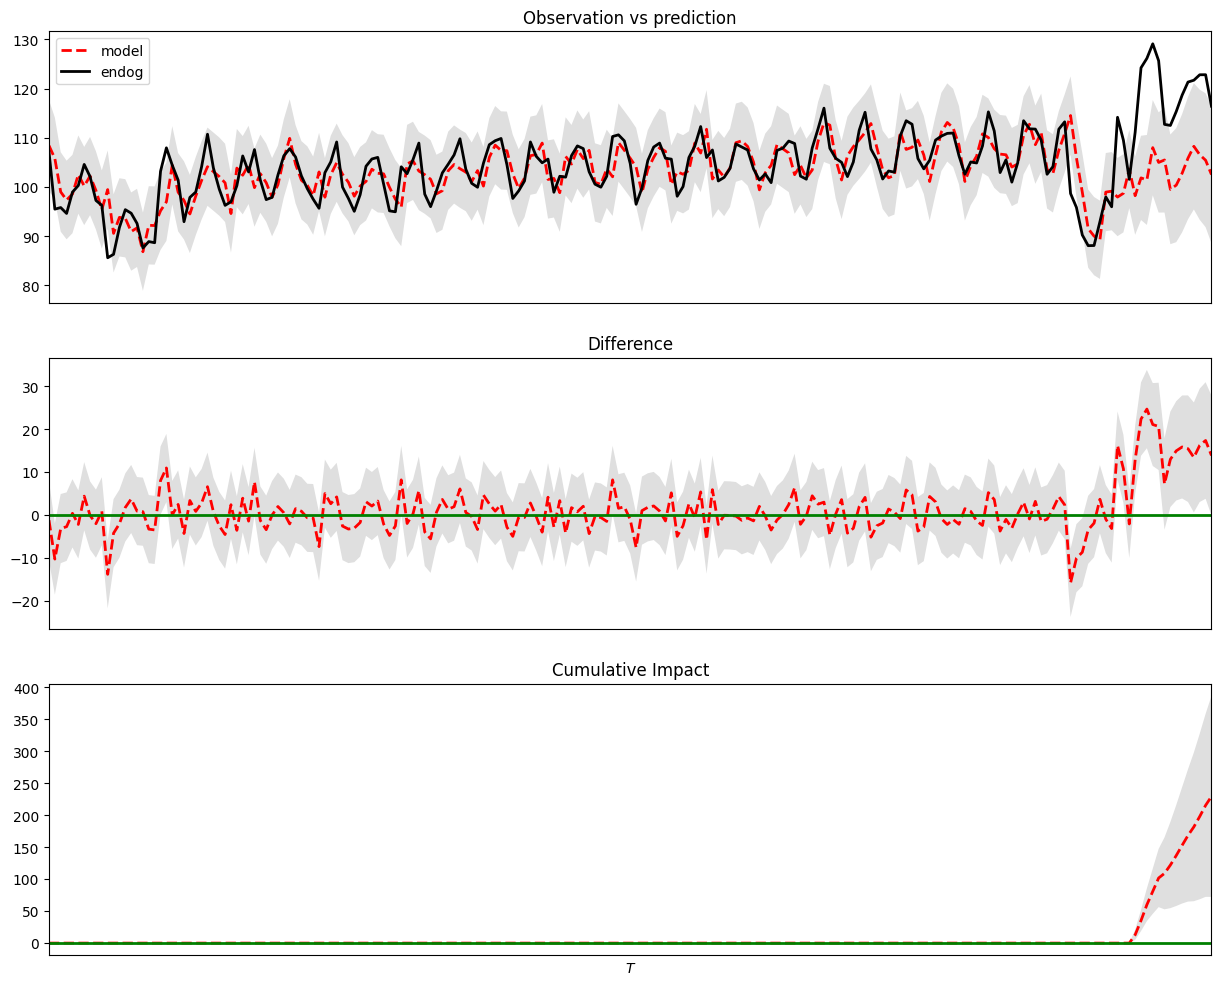

In [69]:
# check single causalimpact results with relup as keys
print("Keys", impact_class.res_sim.keys())
impact_class.res_sim['0.0944'][1].plot()

Starting simulation


100%|██████████| 10/10 [00:22<00:00,  2.20s/it]


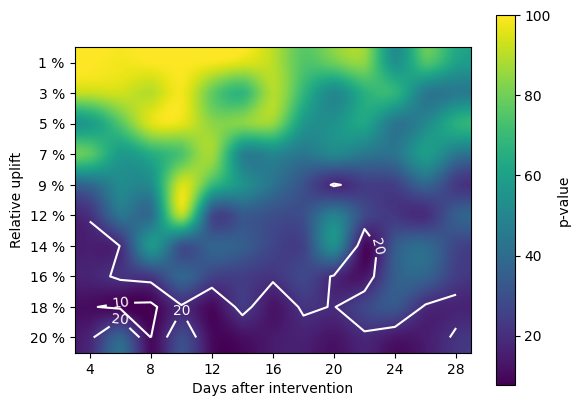

In [70]:
# power analysis by looping over different pre- and post- period lengths

_ = impact_class.power_analyse(relup_list=relup)
fig_power = impact_class.plot_power(alpha=[5,10,20])
display(fig_power)

# Classic causal impact with BSTS

Instructions for updating:
Please use `StructuralTimeSeries.joint_distribution(observed_time_series).log_prob`
Instructions for updating:
`Predictive distributions returned by`tfp.sts.one_step_predictive` will soon compute per-timestep probabilities (treating timesteps as part of the batch shape) instead of a single probability for an entire series (the current approach, in which timesteps are treated as event shape). Please update your code to pass `timesteps_are_event_shape=False` (this will soon be the default) and to explicitly sum over the per-timestep log probabilities if this is required.


2024-07-24 14:00:57.769908: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    126.49             6324.6
Prediction (s.d.)         104.54 (1.22)      5227.13 (60.76)
95% CI                    [102.13, 106.89]   [5106.52, 5344.68]

Absolute effect (s.d.)    21.95 (1.22)       1097.46 (60.76)
95% CI                    [19.6, 24.36]      [979.91, 1218.08]

Relative effect (s.d.)    21.0% (1.16%)      21.0% (1.16%)
95% CI                    [18.75%, 23.3%]    [18.75%, 23.3%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))
Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 126.49. By contrast, in the absence of an
intervention, we would have expected an average response of 104.54.
The 95% interval of this counterfactual prediction is [102.13, 106.89].
Subtracting this prediction f

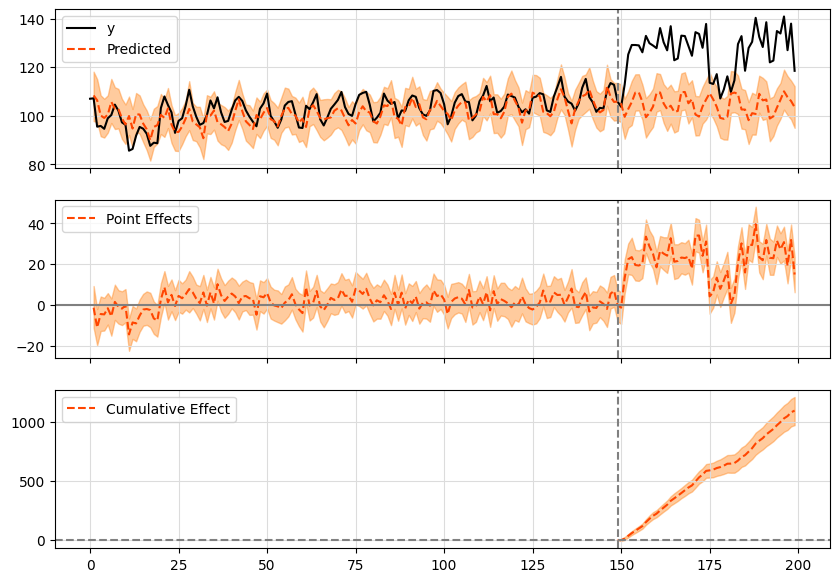

In [79]:
# perform classic causalimpact with tfcausalimpact

# add effect
relup = 0.2
uplift = relup*np.mean(data["target"])
data["target"] = utilities.add_effect(data["target"], uplift, 50)

pre_period = [0, 149]
post_period = [150, 199]

ci = impact.CausalImpact(data, pre_period, post_period, model_args={"period":7})
print(ci.summary())
print(ci.summary(output='report'))
ci.plot()
